# Comparing strategies

Run two strategies on the same data and compare performance side by side.

In [1]:
import sandtable as st

In [2]:
data = st.DataHandler(
    provider=st.CSVProvider("../data/fixtures"),
    universe=["SPY", "QQQ"]
)
data.load("2020-01-01", "2023-12-31")

## Run both strategies

In [3]:
mac = st.MACrossoverStrategy(fast_period=10, slow_period=30)
result_mac = st.run_backtest(strategy=mac, data=data, initial_capital=100_000)

data.reset()

mr = st.MeanReversionStrategy(lookback=20, threshold=2.0)
result_mr = st.run_backtest(strategy=mr, data=data, initial_capital=100_000)

[2026-02-22 18:30:07] INFO:sandtable.api: Running backtest: MACrossoverStrategy on ['QQQ', 'SPY']
[2026-02-22 18:30:07] INFO:sandtable.core.backtest: Starting backtest: SPY,QQQ with 2012 bars
[2026-02-22 18:30:08] INFO:sandtable.core.backtest: Backtest complete: processed 2012 bars
[2026-02-22 18:30:08] INFO:sandtable.api: Backtest finished: return=5.53%, sharpe=0.30
[2026-02-22 18:30:08] INFO:sandtable.api: Running backtest: MeanReversionStrategy on ['QQQ', 'SPY']
[2026-02-22 18:30:08] INFO:sandtable.core.backtest: Starting backtest: SPY,QQQ with 2012 bars
[2026-02-22 18:30:08] INFO:sandtable.core.backtest: Backtest complete: processed 2012 bars
[2026-02-22 18:30:08] INFO:sandtable.api: Backtest finished: return=0.30%, sharpe=0.05


In [4]:
for name, r in [("MA Crossover", result_mac), ("Mean Reversion", result_mr)]:
    m = r.metrics
    print(f"# {name}")
    print(f"\t- Return:  {m.total_return:.2%}")
    print(f"\t- Sharpe:  {m.sharpe_ratio:.3f}")
    print(f"\t- Max DD:  {m.max_drawdown:.2%}")
    print(f"\t- Trades:  {m.num_trades}")
    print()

# MA Crossover
	- Return:  5.53%
	- Sharpe:  0.296
	- Max DD:  5.49%
	- Trades:  64

# Mean Reversion
	- Return:  0.30%
	- Sharpe:  0.055
	- Max DD:  2.60%
	- Trades:  52



## run_comparison

Gives you a performance table, correlation matrix, and a blended equity curve.

In [5]:
comp = st.run_comparison({
    "MA Crossover": result_mac,
    "Mean Reversion": result_mr,
})

comp.performance_table

[2026-02-22 18:30:08] INFO:sandtable.research.compare: Comparing 2 strategies: ['MA Crossover', 'Mean Reversion']


,sharpe_ratio,sortino_ratio,cagr,max_drawdown,total_return,win_rate,profit_factor,avg_trade_pnl,num_trades
strategy,,,,,,,,,
MA Crossover,0.295547,0.421079,0.006768,0.054946,0.055303,0.390625,1.224728,53.13504,64
Mean Reversion,0.054583,0.074665,0.000373,0.026001,0.002981,0.692308,1.219411,9.45467,52


In [6]:
comp.correlation_matrix

,MA Crossover,Mean Reversion
MA Crossover,1.000000,-0.572634
Mean Reversion,-0.572634,1.000000


## Overlay equity curves

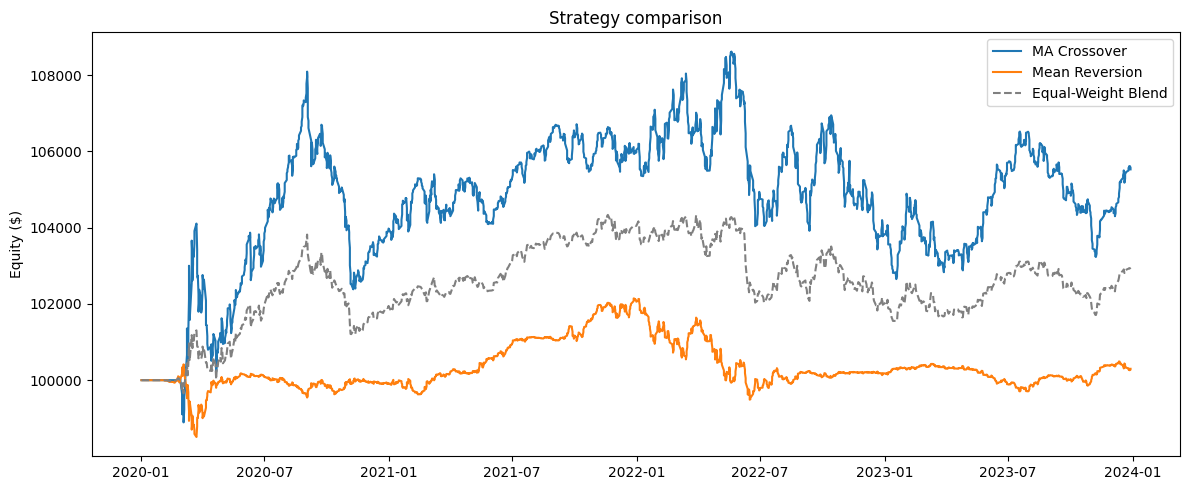

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 5))

for label, r in [("MA Crossover", result_mac), ("Mean Reversion", result_mr)]:
    dates = [pt.timestamp for pt in r.equity_curve]
    equity = [pt.equity for pt in r.equity_curve]
    ax.plot(dates, equity, label=label)

# blended
blend_dates = [pt.timestamp for pt in comp.blended_equity_curve]
blend_eq = [pt.equity for pt in comp.blended_equity_curve]
ax.plot(blend_dates, blend_eq, label="Equal-Weight Blend", linestyle="--", color="gray")

ax.set_title("Strategy comparison")
ax.legend()
ax.set_ylabel("Equity ($)")
plt.tight_layout()